<a href="https://colab.research.google.com/github/theHoodguy4587/Spotify-EDA-Project/blob/main/Automatic_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [6]:
df=pd.read_csv("/content/drive/MyDrive/StudentsPerformance.csv")

summery=df.describe()
missing =df.isnull().sum()
correlations=df.corr(numeric_only=True)

print("Shape:",df.shape)
print("\nMissing Valueas:\n",missing)
print("\nSummary Statistics:\n",summery)
print("\nCorrelations:\n",correlations)

Shape: (1000, 8)

Missing Valueas:
 gender                         0
race/ethnicity                 0
parental level of education    0
lunch                          0
test preparation course        0
math score                     0
reading score                  0
writing score                  0
dtype: int64

Summary Statistics:
        math score  reading score  writing score
count  1000.00000    1000.000000    1000.000000
mean     66.08900      69.169000      68.054000
std      15.16308      14.600192      15.195657
min       0.00000      17.000000      10.000000
25%      57.00000      59.000000      57.750000
50%      66.00000      70.000000      69.000000
75%      77.00000      79.000000      79.000000
max     100.00000     100.000000     100.000000

Correlations:
                math score  reading score  writing score
math score       1.000000       0.817580       0.802642
reading score    0.817580       1.000000       0.954598
writing score    0.802642       0.954598       1.

In [7]:
numeric_cols=df.select_dtypes(include=['int64','float64']).columns
categorical_cols=df.select_dtypes(include=['object']).columns

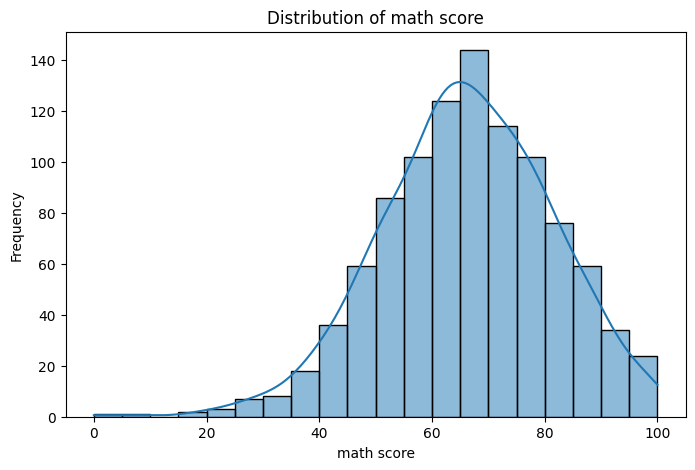

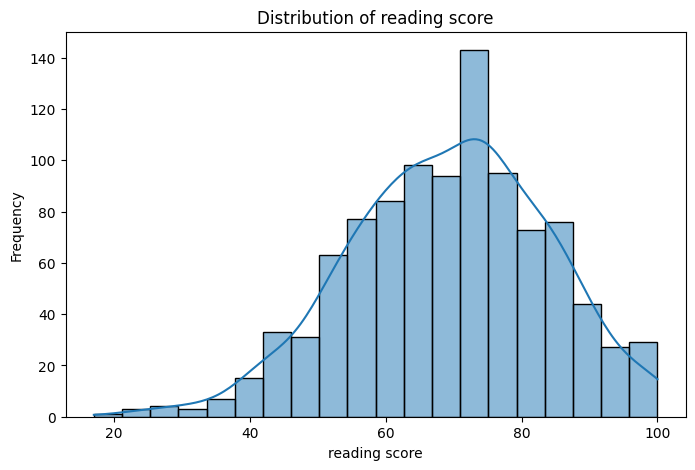

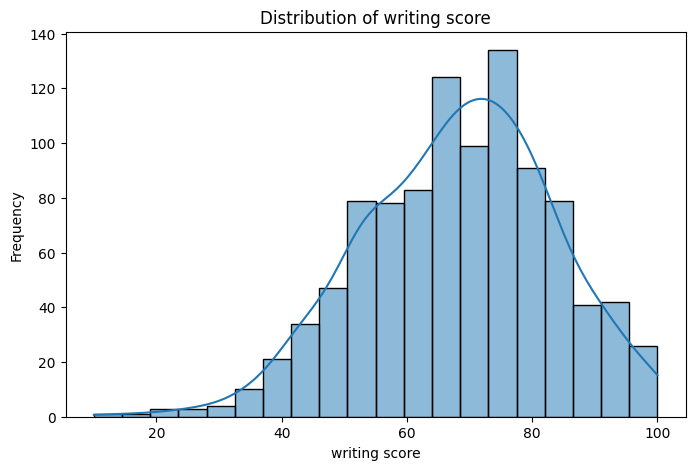

In [8]:
for col in numeric_cols:
  plt.figure(figsize=(8,5))
  sns.histplot(df[col],bins=20,kde=True)
  plt.title(f"Distribution of {col}")
  plt.xlabel(col)
  plt.ylabel("Frequency")
  plt

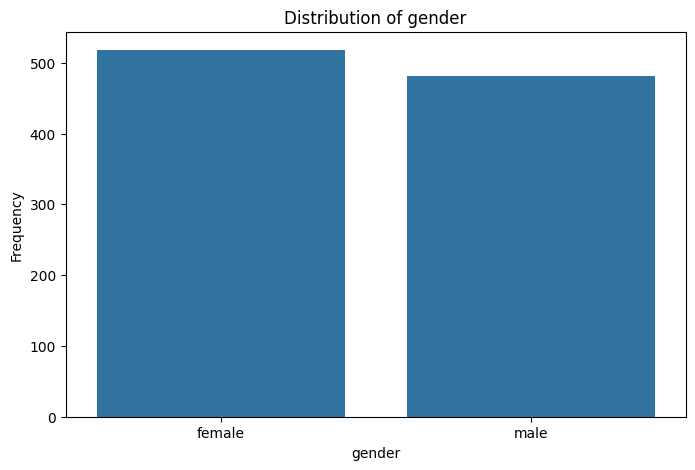

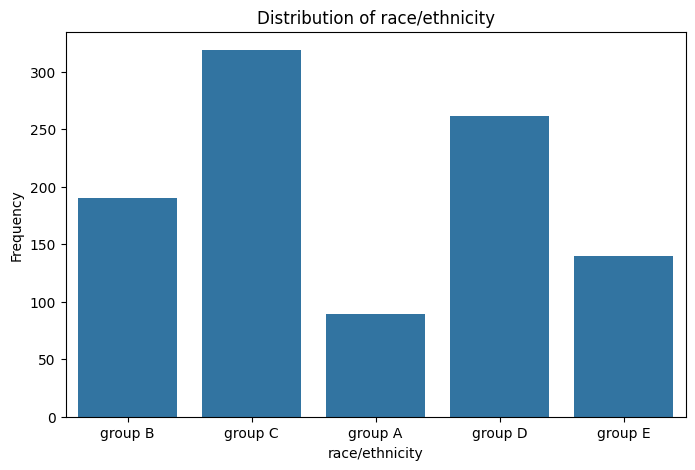

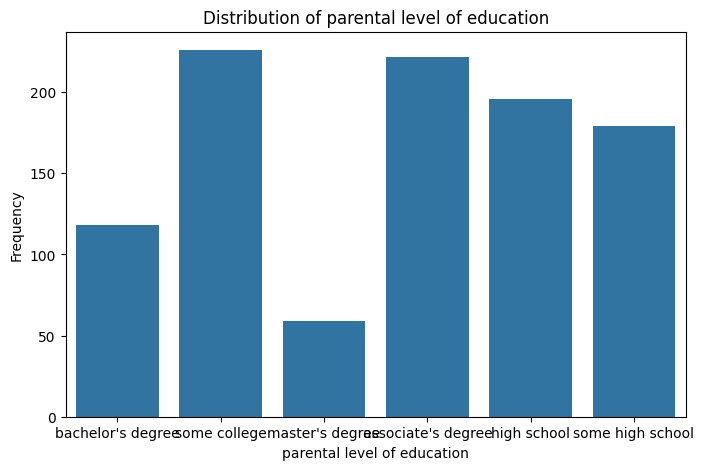

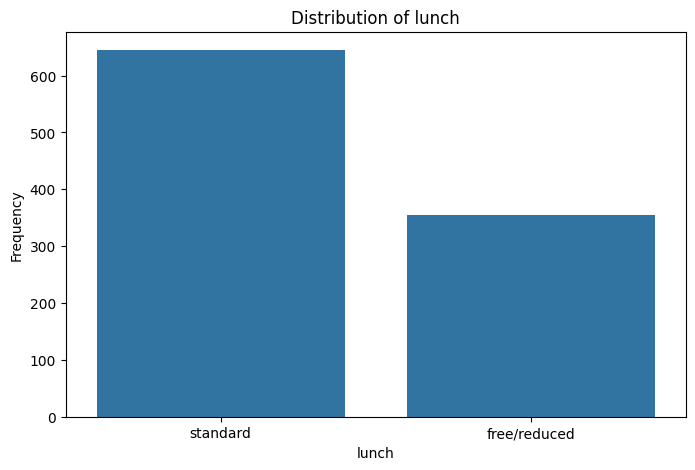

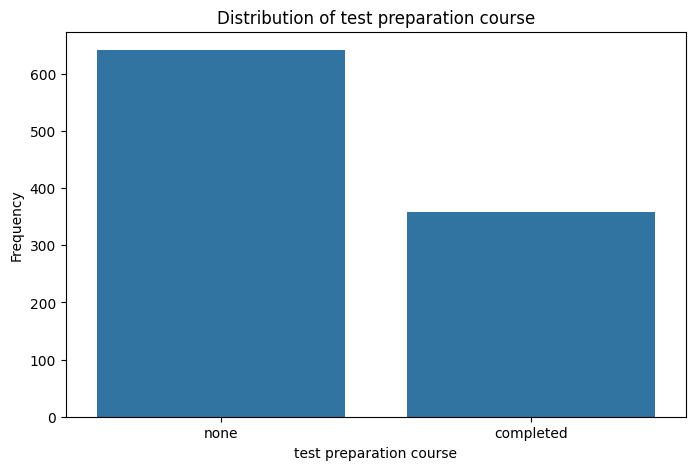

In [9]:
for col in categorical_cols:
  plt.figure(figsize=(8,5))
  sns.countplot(data=df,x=col)
  plt.title(f"Distribution of {col}")
  plt.xlabel(col)
  plt.ylabel("Frequency")
  plt

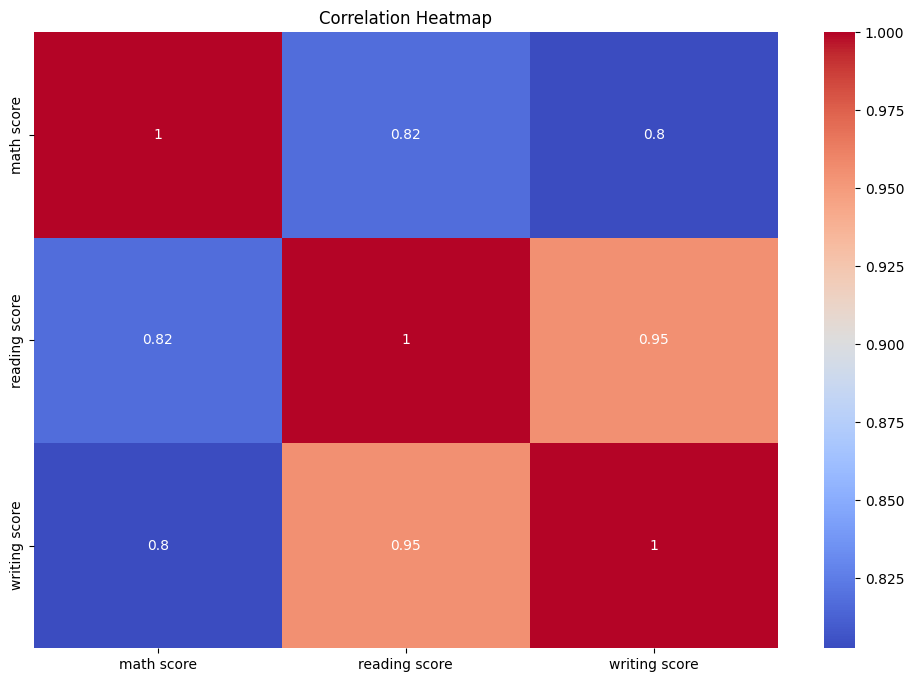

In [10]:
if len(numeric_cols)>1:
  plt.figure(figsize=(12,8))
  sns.heatmap(df[numeric_cols].corr(),annot=True,cmap="coolwarm")
  plt.title("Correlation Heatmap")
  plt.show()

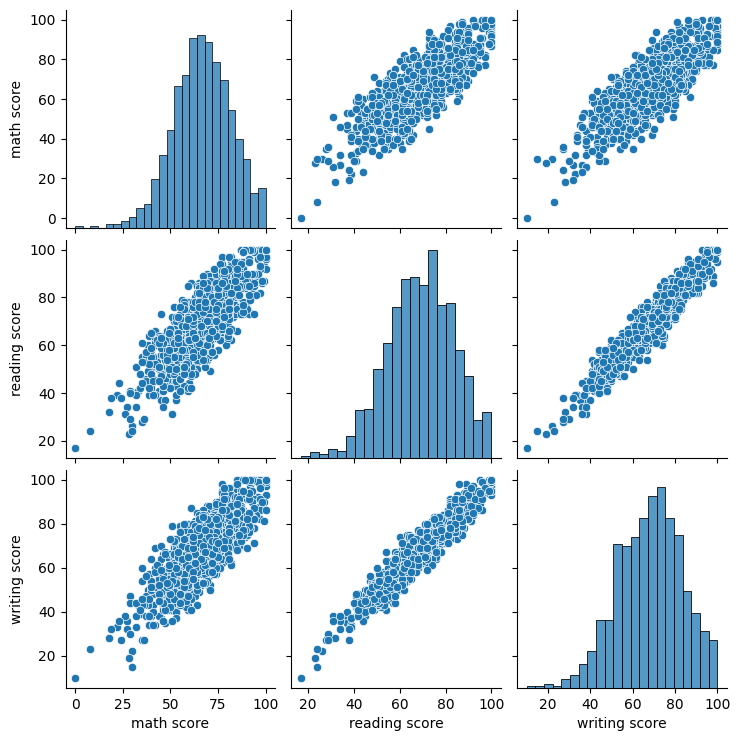

In [11]:
sns.pairplot(df[numeric_cols])
plt.show()

In [12]:
!pip install gradio transformers pandas matplotlib seaborn --quiet


In [1]:

import gradio as gr
from transformers import pipeline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import io
import re
import traceback

try:
    llm = pipeline(
        "text2text-generation",
        model="google/flan-t5-small",
        device=-1
    )
except Exception as e:
    llm = None
    print(" LLM model could not be loaded:", e)



def eda_app(file):
    try:

        df = pd.read_csv(file.name)


        shape_info = df.shape
        missing_info = df.isnull().sum()
        summary_stats = df.describe().transpose()


        summary_text = summary_stats[['mean', 'min', 'max']].to_string()

        prompt = (
            "Analyze the following dataset statistics and provide 3–5 meaningful insights. "
            "Write clearly, avoid repetition, and summarize key trends in simple English.\n\n"
            f"{summary_text}"
        )

        try:
            if llm:
                result = llm(
                    prompt,
                    max_length=200,
                    num_return_sequences=1,
                    temperature=0.7,
                    repetition_penalty=2.0
                )[0]["generated_text"]


                clean_text = (
                    result.replace("<br>", "\n")
                          .replace("<br/>", "\n")
                          .replace("<br />", "\n")
                          .replace("*", "")
                          .replace("-", ".")
                )


                pattern = r"([A-Za-z_]+)\s+(\d+\.\d+)\s+(\d+\.\d+)\s+(\d+\.\d+)"
                matches = re.findall(pattern, clean_text)

                if matches:
                    df_insights = pd.DataFrame(matches, columns=["Feature", "Mean", "Min", "Max"])
                    for col in ["Mean", "Min", "Max"]:
                        df_insights[col] = df_insights[col].astype(float).round(3)
                    insights = df_insights
                else:

                    insights = pd.DataFrame({"Insights": [clean_text]})

            else:
                insights = pd.DataFrame({"Insights": [" LLM not available."]})

        except Exception as e:
            insights = pd.DataFrame({"Insights": [f" LLM generation failed: {str(e)}"]})


        plots = []
        numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
        categorical_cols = df.select_dtypes(include=['object']).columns


        for col in numeric_cols:
            fig, ax = plt.subplots()
            sns.histplot(df[col], bins=20, kde=True, ax=ax)
            ax.set_title(f"Distribution of {col}")
            plt.xticks(rotation=45, ha="right")
            plt.tight_layout()
            buf = io.BytesIO()
            plt.savefig(buf, format="png")
            plt.close(fig)
            buf.seek(0)
            plots.append(Image.open(buf).convert("RGB"))


        if len(numeric_cols) > 1:
            fig, ax = plt.subplots()
            sns.heatmap(df[numeric_cols].corr(), annot=True, cmap="coolwarm", ax=ax)
            ax.set_title("Correlation Heatmap")
            buf = io.BytesIO()
            plt.savefig(buf, format="png")
            plt.close(fig)
            buf.seek(0)
            plots.append(Image.open(buf).convert("RGB"))


        for col in categorical_cols:
            fig, ax = plt.subplots()
            sns.countplot(data=df, x=col, ax=ax)
            ax.set_title(f"Distribution of {col}")
            plt.xticks(rotation=45, ha="right")
            plt.tight_layout()
            buf = io.BytesIO()
            plt.savefig(buf, format="png")
            plt.close(fig)
            buf.seek(0)
            plots.append(Image.open(buf).convert("RGB"))


        summary_output = (
            f"Shape: {shape_info}\n\nMissing Values:\n{missing_info.to_string()}\n\n"
            f"Summary Stats (first 5 rows):\n{summary_stats.head(5).to_string()}"
        )

        return summary_output, insights, plots

    except Exception as e:
        error_details = f" Error: {str(e)}\n\nFull Traceback:\n{traceback.format_exc()}"
        print(error_details)
        return error_details, pd.DataFrame({"Error": [error_details]}), []



demo = gr.Interface(
    fn=eda_app,
    inputs=gr.File(label="Upload CSV Dataset"),
    outputs=[
        gr.Textbox(label="Dataset Summary", lines=20),
        gr.Dataframe(label="AI-Generated Insights (Formatted Table)"),
        gr.Gallery(label="Plots")
    ],
    title="📊 Fast AI-Powered EDA App",
    description="Upload a CSV file to get dataset summary, AI insights, and visualizations quickly."
)


demo.launch(share=True)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/308M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

Device set to use cpu


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://341ddfcace8c332a0e.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
